In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/krzysztofspalinski/deep-learning-methods-project-2.git
!mv deep-learning-methods-project-2 src

Cloning into 'deep-learning-methods-project-2'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 119 (delta 39), reused 98 (delta 24), pack-reused 0
Receiving objects: 100% (119/119), 3.17 MiB | 11.66 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
import tensorflow as tf

class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters, batch_normalization=True, conv_first=False):
    super(ResnetIdentityBlock, self).__init__(name='')
    
    self.residual_layers = []
    
    for i in range(len(filters)):
        
        if conv_first:
            setattr(self, 'conv' + str(i+1), tf.keras.layers.Conv2D(filters[i], kernel_size, padding='same'))
            self.residual_layers.append('conv' + str(i+1))

            if batch_normalization:
                setattr(self, 'bn' + str(i+1), tf.keras.layers.BatchNormalization())
                self.residual_layers.append('bn' + str(i+1))
        
        else:
            if batch_normalization:
                setattr(self, 'bn' + str(i+1), tf.keras.layers.BatchNormalization())
                self.residual_layers.append('bn' + str(i+1))
            
            setattr(self, 'conv' + str(i+1), tf.keras.layers.Conv2D(filters[i], kernel_size, padding='same'))
            self.residual_layers.append('conv' + str(i+1))

            
            
  def call(self, input_tensor, training=False):
    
    x = input_tensor
    
    for layer in self.residual_layers:
        
        if isinstance(layer, tf.keras.layers.Conv2D):
            x = getattr(self, layer)(x)
        else: 
            x = getattr(self, layer)(x, training=False)
        x = tf.nn.relu(x)
        
    x += input_tensor
    return tf.nn.relu(x)

In [4]:
# Loading the data (MNIST)
import numpy as np

mnist = tf.contrib.learn.datasets.load_dataset("mnist")
x_train = mnist.train.images.reshape(mnist.train.images.shape[0], 28, 28, 1)
y_train = np.asarray(mnist.train.labels, dtype=np.int32)
x_test = mnist.test.images.reshape(mnist.test.images.shape[0], 28, 28, 1)
y_test = np.asarray(mnist.test.labels, dtype=np.int32)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-u

In [5]:
x_train = x_train/255
x_test = x_test/255
print(x_train.shape)
print(x_test.shape)

(55000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
from keras.utils.np_utils import to_categorical   

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Using TensorFlow backend.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=5,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.05)

In [0]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

NUM_EPOCHS = 80
learning_rate = 1e-4
BATCH_SIZE=128

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=INPUT_SHAPE))

model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))

model.add(ResnetIdentityBlock((3,3), filters=(64, 64)))
model.add(ResnetIdentityBlock((3,3), filters=(64, 64)))
model.add(ResnetIdentityBlock((3,3), filters=(64, 64)))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.AveragePooling2D(pool_size=8))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.summary()

datagen.fit(x_train)

sgd = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_test, y_test),
                    epochs=NUM_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
resnet_identity_block (Resne (None, 26, 26, 128)       296192    
_________________________________________________________________
resnet_identity_block_1 (Res (None, 26, 26, 128)       296192    
_________________________________________________________________
resnet_identity_block_2 (Res (None, 26, 26, 128)       296192    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        73792     
_________________________________________________________________
resnet_identity_block_3 (Res (None, 26, 26, 64)        74368     
_________________________________________________________________
resnet_identity_block_4 (Res (None, 26, 26, 64)        7

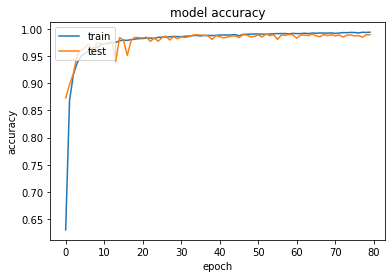

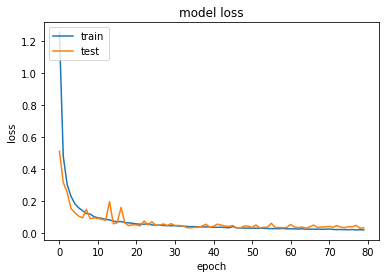

In [12]:
history1 = model.history.history

# summarize history for accuracy
plt.plot(history1['acc'])
plt.plot(history1['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()